<a href="https://colab.research.google.com/github/JinNakagawa/Week8-Assignment/blob/main/Group_13_Midterm_MLB_EDA_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **MLB Perfomance Analysis — Exploring Team and Player Data from the 2024 Season**

## Dylan O'Connor, Jin Nakagawa, Douglas Moss
  
**API:** Public MLB Stats API — https://statsapi.mlb.com/api/v1


### **Overview**
This project analyzes Major League Baseball (MLB) performance data using the official MLB Stats API. We begin with a detailed, team-level examination of the 2024 season across offensive and defensive dimensions, then expand to explore individual player stats. The goal is to identify what truly drives team success and what teams should priortize when shaping their rosters.

### **Target Audience**
- **Primary:** MLB analytics and front-office teams seeking to understand the data-driven foundations of winning and resource efficiency.  
- **Secondary:** Baseball fans and analysts interested in uncovering deeper patterns in league performance, strategy, and evolution.

### **Motivation**
Team outcomes in baseball reflect a complex interplay of hitting, pitching, defense, and environment. By combining official game, player, and team statistics, this analysis explores:

- What distinguishes good teams from bad teams through the lens of home vs. away records, overall wins vs. losses, and run-differentials.
- The relative impact of hitting, pitching, and fielding on winning.
- Which offensive and defensive metrics best correlate with team success in a single season (2024).  
- How individual player stats contribute to team performance.  

### Road Map
1. **Data acquisition and cleaning** — Pull team, player, and schedule data from the MLB Stats API.  
2. **Part A: Team-level analysis (2024)** — Win rates, run differentials, ballpark scoring, hitting/pitching/defense metrics.  
3. **Part B: Player-level analysis (2024)** — Top performers and relationships between player stats and team success.  
 4. **Conclusions & Future Work** — Key insights and ideas for further modeling or dataset integration.


### **Part A: Preliminary Data Pull and Checks**

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)

# API constants
MLB_API_BASE   = "https://statsapi.mlb.com/api/v1"
MLB_SEASON_YEAR = 2024
MLB_START_DATE  = "2024-03-20"
MLB_END_DATE    = "2024-10-01"


In [ ]:
def mlb_api_get(endpoint, params=None):
    if params is None:
        params = {}
    if not endpoint.startswith("/"):
        endpoint = "/" + endpoint
    url = MLB_API_BASE + endpoint
    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()


In [ ]:
# Test
test_call = mlb_api_get("/sports")
print("API connected successfully!") if test_call else print("Check API connection.")


API connected successfully!


In [ ]:
teams_json = mlb_api_get("/teams", {
    "sportId": 1, # ID for the MLB
    "season": MLB_SEASON_YEAR,
    "activeStatus": "Y"})

mlb_teams_2024 = pd.json_normalize(teams_json["teams"])[
    ["id", "name", "abbreviation", "teamName", "franchiseName", "venue.name"]].rename(columns={
    "id": "team_id",
    "name": "team_name",
    "abbreviation": "team_abbr",
    "venue.name": "venue_name"})

print(f"Number of active MLB teams: {mlb_teams_2024['team_id'].nunique()}")
mlb_teams_2024.head(10)



Number of active MLB teams: 30


,team_id,team_name,team_abbr,teamName,franchiseName,venue_name
0,133,Oakland Athletics,OAK,Athletics,Oakland,Oakland Coliseum
1,134,Pittsburgh Pirates,PIT,Pirates,Pittsburgh,PNC Park
2,135,San Diego Padres,SD,Padres,San Diego,Petco Park
3,136,Seattle Mariners,SEA,Mariners,Seattle,T-Mobile Park
4,137,San Francisco Giants,SF,Giants,San Francisco,Oracle Park
5,138,St. Louis Cardinals,STL,Cardinals,St. Louis,Busch Stadium
6,139,Tampa Bay Rays,TB,Rays,Tampa Bay,Tropicana Field
7,140,Texas Rangers,TEX,Rangers,Texas,Globe Life Field
8,141,Toronto Blue Jays,TOR,Blue Jays,Toronto,Rogers Centre
9,142,Minnesota Twins,MIN,Twins,Minnesota,Target Field


In [ ]:
schedule_json = mlb_api_get("/schedule", {
    "sportId": 1,
    "startDate": MLB_START_DATE,
    "endDate": MLB_END_DATE,
    "gameType": "R"   # Regular season
})

records = []
for day in schedule_json.get("dates", []):
    for g in day.get("games", []):
        records.append({
            "game_id": g.get("gamePk"),
            "date": g.get("officialDate"),
            "status": (g.get("status") or {}).get("detailedState"),
            "venue_name": (g.get("venue") or {}).get("name"),
            "home_team_id": ((g.get("teams") or {}).get("home") or {}).get("team", {}).get("id"),
            "home_team": ((g.get("teams") or {}).get("home") or {}).get("team", {}).get("name"),
            "home_score": ((g.get("teams") or {}).get("home") or {}).get("score"),
            "away_team_id": ((g.get("teams") or {}).get("away") or {}).get("team", {}).get("id"),
            "away_team": ((g.get("teams") or {}).get("away") or {}).get("team", {}).get("name"),
            "away_score": ((g.get("teams") or {}).get("away") or {}).get("score"),})

schedule_raw_2024 = pd.DataFrame.from_records(records)
print(f"Total games retrieved: {len(schedule_raw_2024)}")
schedule_raw_2024.head(3)




Total games retrieved: 2469


,game_id,date,status,venue_name,home_team_id,home_team,home_score,away_team_id,away_team,away_score
0,745444,2024-03-20,Final,Gocheok Sky Dome,135,San Diego Padres,2.0,119,Los Angeles Dodgers,5.0
1,746175,2024-03-21,Final,Gocheok Sky Dome,119,Los Angeles Dodgers,11.0,135,San Diego Padres,15.0
2,747060,2024-03-28,Final,Oriole Park at Camden Yards,110,Baltimore Orioles,11.0,108,Los Angeles Angels,3.0


In [ ]:
# Filter out exhibition games
mlb_ids = set(mlb_teams_2024["team_id"])
team_games_2024 = schedule_raw_2024[
    schedule_raw_2024["home_team_id"].isin(mlb_ids) &
    schedule_raw_2024["away_team_id"].isin(mlb_ids)].copy()

team_games_2024.head(3)


,game_id,date,status,venue_name,home_team_id,home_team,home_score,away_team_id,away_team,away_score
0,745444,2024-03-20,Final,Gocheok Sky Dome,135,San Diego Padres,2.0,119,Los Angeles Dodgers,5.0
1,746175,2024-03-21,Final,Gocheok Sky Dome,119,Los Angeles Dodgers,11.0,135,San Diego Padres,15.0
2,747060,2024-03-28,Final,Oriole Park at Camden Yards,110,Baltimore Orioles,11.0,108,Los Angeles Angels,3.0


In [ ]:
schedule_raw_2024.info()
print("\nMissing values per column:")
print(schedule_raw_2024.isna().sum())
schedule_raw_2024.sample(5)
# The 37 missing home_score / away_score values indicate number of postponed games.
# The status column will flag completed vs postponed games.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   game_id       2469 non-null   int64  
 1   date          2469 non-null   object 
 2   status        2469 non-null   object 
 3   venue_name    2469 non-null   object 
 4   home_team_id  2469 non-null   int64  
 5   home_team     2469 non-null   object 
 6   home_score    2432 non-null   float64
 7   away_team_id  2469 non-null   int64  
 8   away_team     2469 non-null   object 
 9   away_score    2432 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 193.0+ KB

Missing values per column:
game_id          0
date             0
status           0
venue_name       0
home_team_id     0
home_team        0
home_score      37
away_team_id     0
away_team        0
away_score      37
dtype: int64


,game_id,date,status,venue_name,home_team_id,home_team,home_score,away_team_id,away_team,away_score
1553,746851,2024-07-24,Final,Wrigley Field,112,Chicago Cubs,2.0,158,Milwaukee Brewers,3.0
1332,746285,2024-07-04,Final,Kauffman Stadium,118,Kansas City Royals,8.0,139,Tampa Bay Rays,10.0
230,746975,2024-04-14,Final,Fenway Park,111,Boston Red Sox,5.0,108,Los Angeles Angels,4.0
2162,746344,2024-09-07,Final,Minute Maid Park,117,Houston Astros,11.0,109,Arizona Diamondbacks,5.0
1258,745159,2024-06-29,Final,Busch Stadium,138,St. Louis Cardinals,4.0,113,Cincinnati Reds,9.0


In [ ]:
# Clean scores
team_games_2024["home_score"] = pd.to_numeric(team_games_2024["home_score"], errors="coerce")
team_games_2024["away_score"] = pd.to_numeric(team_games_2024["away_score"], errors="coerce")

# Game outcome flags
team_games_2024["is_final"] = team_games_2024["status"].str.contains("Final", case=False, na=False)
team_games_2024["is_postponed"] = team_games_2024["status"].str.contains(
    "Postponed|Suspended|Delayed Start", case=False, na=False
)

# Win indicators
team_games_2024["home_win"] = (team_games_2024["home_score"] > team_games_2024["away_score"]).astype("Int64")
team_games_2024["away_win"] = (team_games_2024["away_score"] > team_games_2024["home_score"]).astype("Int64")

# Run metrics
team_games_2024["total_runs"] = team_games_2024[["home_score", "away_score"]].sum(axis=1, min_count=1)
team_games_2024["home_run_diff"] = team_games_2024["home_score"] - team_games_2024["away_score"]

team_games_2024.head(5)


,game_id,date,status,venue_name,home_team_id,home_team,home_score,away_team_id,away_team,away_score,is_final,is_postponed,home_win,away_win,total_runs,home_run_diff
0,745444,2024-03-20,Final,Gocheok Sky Dome,135,San Diego Padres,2.0,119,Los Angeles Dodgers,5.0,True,False,0,1,7.0,-3.0
1,746175,2024-03-21,Final,Gocheok Sky Dome,119,Los Angeles Dodgers,11.0,135,San Diego Padres,15.0,True,False,0,1,26.0,-4.0
2,747060,2024-03-28,Final,Oriole Park at Camden Yards,110,Baltimore Orioles,11.0,108,Los Angeles Angels,3.0,True,False,1,0,14.0,8.0
3,746737,2024-03-28,Final,Great American Ball Park,113,Cincinnati Reds,8.0,120,Washington Nationals,2.0,True,False,1,0,10.0,6.0
4,745445,2024-03-28,Final,Petco Park,135,San Diego Padres,6.0,137,San Francisco Giants,4.0,True,False,1,0,10.0,2.0


###**Part B: Team-Level Analysis (2024)**

### General Win-Loss Data

In [ ]:
# Home team summary
home_summary = (
    team_games_2024.groupby("home_team")
    .agg(
        games_played=("game_id", "count"),
        home_win_rate=("home_win", "mean"),
        avg_home_runs=("home_score", "mean"),
        avg_away_runs_allowed=("away_score", "mean"),
        pct_postponed=("is_postponed", "mean")
    )
    .reset_index()
)

# Away team summary
away_summary = (
    team_games_2024.groupby("away_team")
    .agg(
        games_played=("game_id", "count"),
        away_win_rate=("away_win", "mean"),
        avg_away_runs=("away_score", "mean"),
        avg_home_runs_allowed=("home_score", "mean")
    )
    .reset_index()
)

team_summary_2024 = home_summary.merge(
    away_summary, left_on="home_team", right_on="away_team", suffixes=("_home", "_away")
)
team_summary_2024.rename(columns={"home_team": "team_name"}, inplace=True)
team_summary_2024.drop(columns=["away_team"], inplace=True)

# Overall win rate (simple average of home/away)
team_summary_2024["overall_win_rate"] = team_summary_2024[["home_win_rate", "away_win_rate"]].mean(axis=1)
team_summary_2024.head()


,team_name,games_played_home,home_win_rate,avg_home_runs,avg_away_runs_allowed,pct_postponed,games_played_away,away_win_rate,avg_away_runs,avg_home_runs_allowed,overall_win_rate
0,Arizona Diamondbacks,81,0.543,5.642,5.086,0.000,82,0.549,5.296,4.642,0.546
1,Atlanta Braves,88,0.523,3.901,3.889,0.080,84,0.512,4.790,3.605,0.517
2,Baltimore Orioles,82,0.537,4.630,4.321,0.012,82,0.573,5.024,4.293,0.555
3,Boston Red Sox,83,0.458,4.476,4.890,0.012,81,0.531,4.753,4.321,0.494
4,Chicago Cubs,82,0.537,3.938,3.407,0.012,82,0.476,5.148,4.852,0.506


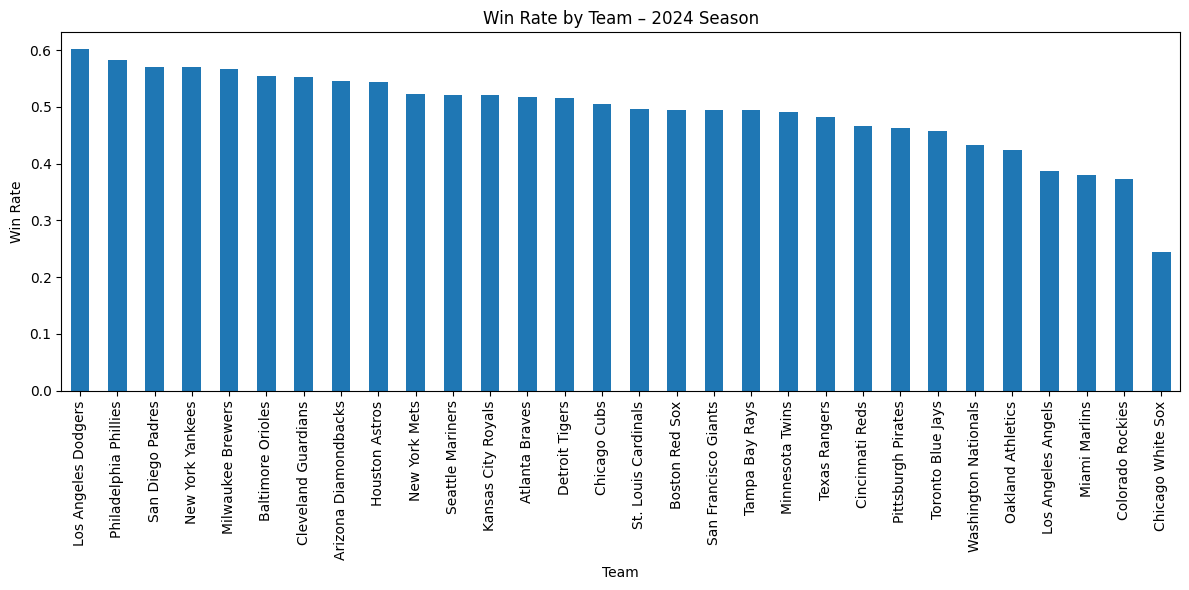

In [ ]:
team_summary_2024.sort_values("overall_win_rate", ascending=False).plot(
    x="team_name", y="overall_win_rate", kind="bar", figsize=(12,6), legend=False
)
plt.title("Win Rate by Team – 2024 Season")
plt.ylabel("Win Rate")
plt.xlabel("Team")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Home vs. Away Wins

In [ ]:
# League-wide home vs away summary
league_home_win_rate = team_summary_2024["home_win_rate"].mean()
league_away_win_rate = team_summary_2024["away_win_rate"].mean()
league_overall_win_rate = team_summary_2024["overall_win_rate"].mean()

league_summary = pd.DataFrame({
    "Category": ["Home Win Rate", "Away Win Rate", "Overall Win Rate"],
    "League Average": [league_home_win_rate, league_away_win_rate, league_overall_win_rate]
})

display(league_summary.style.format({"League Average": "{:.3f}"}).hide(axis="index"))


Category,League Average
Home Win Rate,0.514
Away Win Rate,0.471
Overall Win Rate,0.493


**Observation:** Advantage to playing at home vs. away

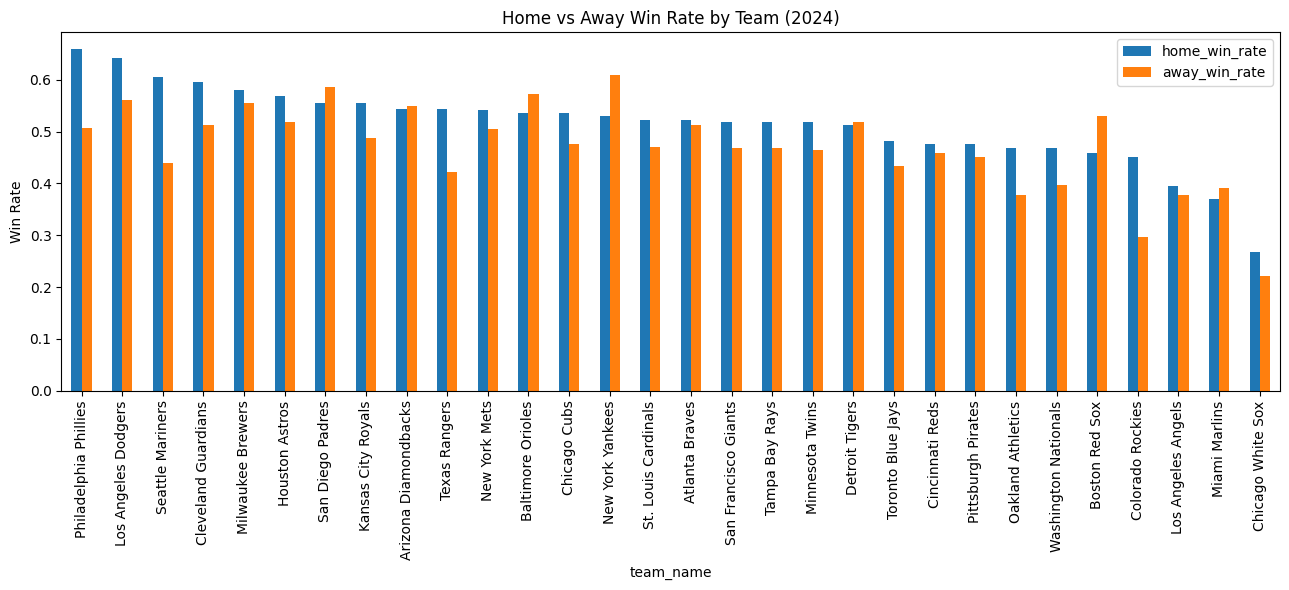

In [ ]:
# Add home advantage metric
team_summary_2024["home_advantage"] = (
    team_summary_2024["home_win_rate"] - team_summary_2024["away_win_rate"]
)

# Visualize win rates
team_summary_2024.sort_values("home_win_rate", ascending=False).plot(
    x="team_name", y=["home_win_rate", "away_win_rate"], kind="bar", figsize=(13,6)
)
plt.title("Home vs Away Win Rate by Team (2024)")
plt.ylabel("Win Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Run Differentials

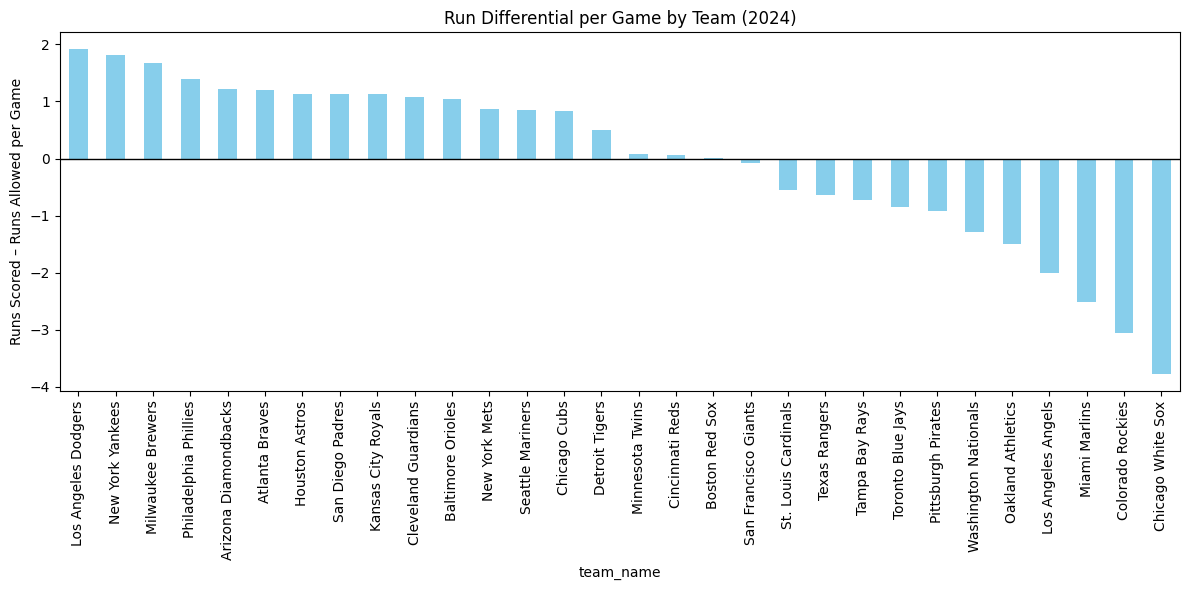

In [ ]:
team_summary_2024["run_diff_per_game"] = (
    (team_summary_2024["avg_home_runs"] + team_summary_2024["avg_away_runs"])
    - (team_summary_2024["avg_home_runs_allowed"] + team_summary_2024["avg_away_runs_allowed"])
)

# Visualize run differential per game
team_summary_2024.sort_values("run_diff_per_game", ascending=False).plot(
    x="team_name", y="run_diff_per_game", kind="bar", color="skyblue", figsize=(12,6), legend=False
)
plt.title("Run Differential per Game by Team (2024)")
plt.ylabel("Runs Scored – Runs Allowed per Game")
plt.xticks(rotation=90)
plt.axhline(0, color="black", lw=1)
plt.tight_layout()
plt.show()


In [ ]:
# Full 2024 MLB postseason list (Division Winners + Wild Cards)
playoff_teams_2024 = [
    # National League
    "Los Angeles Dodgers", "Atlanta Braves", "Milwaukee Brewers",
    "Philadelphia Phillies", "San Diego Padres", "New York Mets",
    # American League
    "New York Yankees", "Baltimore Orioles", "Houston Astros",
    "Texas Rangers", "Cleveland Guardians", "Seattle Mariners"]

# Add playoff flag directly to team_summary_2024
team_summary_2024["Made_Playoffs"] = team_summary_2024["team_name"].isin(playoff_teams_2024)
team_summary_2024["Made_Playoffs_Label"] = team_summary_2024["Made_Playoffs"].map({True:"Yes", False:"No"})

In [ ]:
# Make sure numeric columns are clean
for c in ["home_win_rate","away_win_rate","overall_win_rate","run_diff_per_game"]:
    team_summary_2024[c] = pd.to_numeric(team_summary_2024[c], errors="coerce")

# Rank each metric (1 = best)
team_summary_2024["Rank_Overall"] = team_summary_2024["overall_win_rate"].rank(ascending=False).astype(int)
team_summary_2024["Rank_Home"]    = team_summary_2024["home_win_rate"].rank(ascending=False).astype(int)
team_summary_2024["Rank_Away"]    = team_summary_2024["away_win_rate"].rank(ascending=False).astype(int)
team_summary_2024["Rank_RunDiff"] = team_summary_2024["run_diff_per_game"].rank(ascending=False).astype(int)

# Select columns and sort by overall rank
team_rank_table = team_summary_2024[[
    "team_name",
    "overall_win_rate","Rank_Overall",
    "home_win_rate","Rank_Home",
    "away_win_rate","Rank_Away",
    "run_diff_per_game","Rank_RunDiff",
    "Made_Playoffs_Label"
]].sort_values("Rank_Overall").reset_index(drop=True)

# Round numbers for cleaner display
team_rank_table["overall_win_rate"] = team_rank_table["overall_win_rate"].round(3)
team_rank_table["home_win_rate"] = team_rank_table["home_win_rate"].round(3)
team_rank_table["away_win_rate"] = team_rank_table["away_win_rate"].round(3)
team_rank_table["run_diff_per_game"] = team_rank_table["run_diff_per_game"].round(2)

team_rank_table.head(15)

,team_name,overall_win_rate,Rank_Overall,home_win_rate,Rank_Home,away_win_rate,Rank_Away,run_diff_per_game,Rank_RunDiff,Made_Playoffs_Label
0,Los Angeles Dodgers,0.601,1,0.642,2,0.561,4,1.93,1,Yes
1,Philadelphia Phillies,0.582,2,0.659,1,0.506,12,1.40,4,Yes
2,San Diego Padres,0.57,3,0.556,7,0.585,2,1.12,8,Yes
3,New York Yankees,0.57,4,0.53,14,0.61,1,1.81,2,Yes
4,Milwaukee Brewers,0.567,5,0.58,5,0.554,5,1.68,3,Yes
5,Baltimore Orioles,0.555,6,0.537,12,0.573,3,1.04,11,Yes
6,Cleveland Guardians,0.554,7,0.595,4,0.512,10,1.08,10,Yes
7,Arizona Diamondbacks,0.546,8,0.543,9,0.549,6,1.21,5,No
8,Houston Astros,0.543,9,0.568,6,0.519,8,1.13,7,Yes
9,New York Mets,0.524,10,0.541,11,0.506,13,0.88,12,Yes


**Observation:** Naturally, teams with high win-rates and run differentials made the playoffs. However, select exceptions exist. For one, the Arizona Diamondbacks performed well, placing 8th in overall win-rate and 5th in run-differential. However, they belong in a competitive division including the Dodgers and Padres, which explains why they did not make the playoff cutoff.

## Team Hitting, Pitching, Fielding Stats: Deep Dive

### Hitting

In [ ]:
import numpy as np
import pandas as pd

# Helper
def coerce_numeric_cols(table, cols):
    for c in cols:
        if c in table.columns:
            table[c] = pd.to_numeric(table[c], errors="coerce")
    return table

def safe_div(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    with np.errstate(divide='ignore', invalid='ignore'):
        out = num / den
    return out.replace([np.inf, -np.inf], np.nan)

#  Ensure hitting_stats_2024 exists
if 'hitting_stats_2024' not in locals():
    if 'hitting_df' in locals():  # you may have created this earlier
        hitting_stats_2024 = hitting_df.copy()
    else:
        # Build from API
        hitting_json = mlb_api_get("/teams/stats", {"season": 2024, "group": "hitting", "sportIds": 1})
        hitting_stats_2024 = pd.json_normalize(hitting_json["stats"][0]["splits"])[
            ["team.id","team.name","stat.avg","stat.ops","stat.homeRuns","stat.runs"]
        ].rename(columns={
            "team.id":"team_id","team.name":"team_name",
            "stat.avg":"AVG","stat.ops":"OPS","stat.homeRuns":"HR","stat.runs":"Runs"})

# Ensure pitching_stats_2024 exists
if 'pitching_stats_2024' not in locals():
    if 'pitching_df' in locals():
        pitching_stats_2024 = pitching_df.copy()
    else:
        pitching_json = mlb_api_get("/teams/stats", {"season": 2024, "group": "pitching", "sportIds": 1})
        pitching_stats_2024 = pd.json_normalize(pitching_json["stats"][0]["splits"])[
            ["team.id","team.name","stat.era","stat.whip","stat.strikeOuts","stat.hits","stat.runs"]
        ].rename(columns={
            "team.id":"team_id","team.name":"team_name",
            "stat.era":"ERA","stat.whip":"WHIP","stat.strikeOuts":"SO",
            "stat.hits":"Hits_Allowed","stat.runs":"Runs_Allowed"})

# Ensure fielding_stats_2024 exists
if 'fielding_stats_2024' not in locals():
    if 'fielding_df' in locals():
        fielding_stats_2024 = fielding_df.copy()
    else:
        fielding_json = mlb_api_get("/teams/stats", {"season": 2024, "group": "fielding", "sportIds": 1})
        fielding_stats_2024 = pd.json_normalize(fielding_json["stats"][0]["splits"])[
            ["team.id","team.name","stat.fielding","stat.errors","stat.putOuts","stat.assists"]
        ].rename(columns={
            "team.id":"team_id","team.name":"team_name",
            "stat.fielding":"FieldingPct","stat.errors":"Errors",
            "stat.putOuts":"Putouts","stat.assists":"Assists"})

# Coerce numerics before math
hitting_stats_2024  = coerce_numeric_cols(hitting_stats_2024,  ["AVG","OPS","HR","Runs"])
pitching_stats_2024 = coerce_numeric_cols(pitching_stats_2024, ["ERA","WHIP","SO","Hits_Allowed","Runs_Allowed"])
fielding_stats_2024 = coerce_numeric_cols(fielding_stats_2024, ["FieldingPct","Errors","Putouts","Assists"])


In [ ]:
#Quick check

print(hitting_stats_2024.dtypes)
print(pitching_stats_2024.dtypes)
print(fielding_stats_2024.dtypes)


team_id        int64
team_name     object
AVG          float64
OPS          float64
HR             int64
Runs           int64
dtype: object
team_id           int64
team_name        object
ERA             float64
WHIP            float64
SO                int64
Hits_Allowed      int64
Runs_Allowed      int64
dtype: object
team_id          int64
team_name       object
FieldingPct    float64
Errors           int64
Putouts          int64
Assists          int64
dtype: object


In [ ]:
# Merging with main team_summary_2024 for simplicity
team_stats_full_2024 = (
    hitting_stats_2024
    .merge(pitching_stats_2024, on="team_name")
    .merge(fielding_stats_2024, on="team_name")
    .merge(
        team_summary_2024[["team_name","overall_win_rate","run_diff_per_game"]],
        on="team_name", how="left"))



In [ ]:
# Add playoff flags to team_stats_full_2024
team_stats_full_2024["Made_Playoffs"] = team_stats_full_2024["team_name"].isin(playoff_teams_2024)
team_stats_full_2024["Made_Playoffs_Label"] = team_stats_full_2024["Made_Playoffs"].map({True:"Yes", False:"No"})


In [ ]:
# Top offenses scored
offense_summary = team_stats_full_2024.sort_values("OPS", ascending=False)[
    ["team_name","AVG","OPS","HR","Runs","overall_win_rate", "Made_Playoffs"]]
offense_summary.head(10)

,team_name,AVG,OPS,HR,Runs,overall_win_rate,Made_Playoffs
3,Los Angeles Dodgers,0.258,0.781,233,842,0.601,True
1,Arizona Diamondbacks,0.263,0.777,211,886,0.546,False
8,New York Yankees,0.248,0.762,237,815,0.57,True
4,Philadelphia Phillies,0.257,0.750,198,784,0.582,True
6,Baltimore Orioles,0.250,0.750,235,786,0.555,True
0,San Diego Padres,0.263,0.744,190,760,0.57,True
5,Boston Red Sox,0.252,0.742,194,751,0.494,False
2,Houston Astros,0.262,0.740,190,740,0.543,True
11,New York Mets,0.246,0.734,207,768,0.524,True
7,Milwaukee Brewers,0.248,0.729,177,777,0.567,True


### Best Offensive Metric?

In [ ]:
offense_corr = team_stats_full_2024[["overall_win_rate","AVG","OPS","HR","Runs",]].corr().round(2)
display(offense_corr)


,overall_win_rate,AVG,OPS,HR,Runs
overall_win_rate,1.00,0.63,0.79,0.66,0.82
AVG,0.63,1.00,0.86,0.54,0.80
OPS,0.79,0.86,1.00,0.84,0.96
HR,0.66,0.54,0.84,1.00,0.79
Runs,0.82,0.80,0.96,0.79,1.00


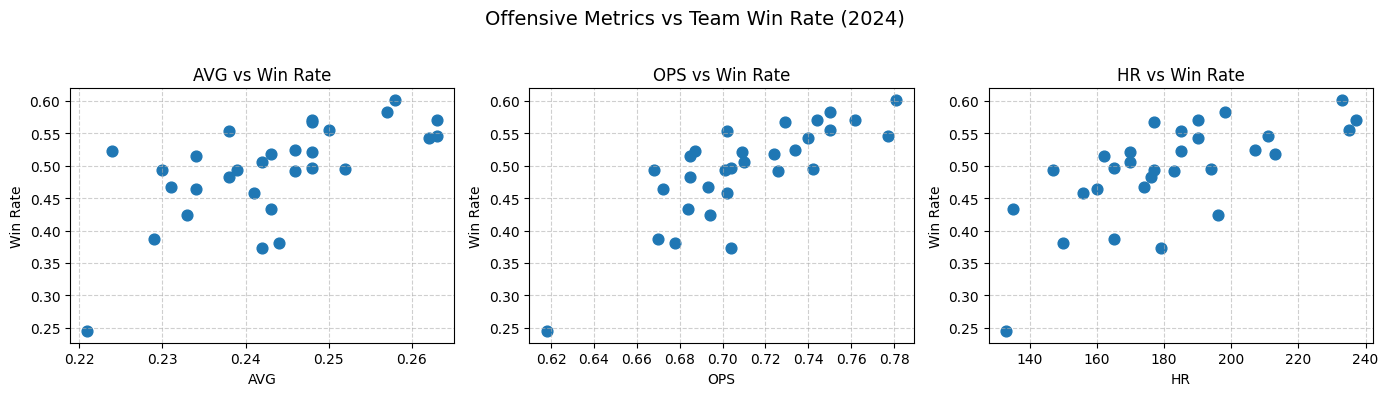

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
metrics = ["AVG","OPS","HR"]

for i, m in enumerate(metrics):
    axes[i].scatter(team_stats_full_2024[m], team_stats_full_2024["overall_win_rate"], s=60)
    axes[i].set_title(f"{m} vs Win Rate")
    axes[i].set_xlabel(m)
    axes[i].set_ylabel("Win Rate")
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.suptitle("Offensive Metrics vs Team Win Rate (2024)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


## Pitching

In [ ]:
# Best and worst ERA/WHIP
# ERA: Average number of earned runs allowed by pitching per 9 innings.
# WHIP: Average number of baserunners allowed per inning

pitching_summary = team_stats_full_2024.sort_values("ERA")[["team_name","ERA","WHIP","SO","Runs_Allowed","overall_win_rate", "Made_Playoffs"]]
pitching_summary.head(10)

,team_name,ERA,WHIP,SO,Runs_Allowed,overall_win_rate,Made_Playoffs
14,Atlanta Braves,3.49,1.20,1553,607,0.517,True
28,Seattle Mariners,3.49,1.08,1416,607,0.522,True
23,Detroit Tigers,3.61,1.16,1354,642,0.515,False
21,Cleveland Guardians,3.61,1.20,1410,621,0.554,True
7,Milwaukee Brewers,3.65,1.23,1373,641,0.567,True
8,New York Yankees,3.74,1.24,1457,668,0.57,True
2,Houston Astros,3.74,1.24,1479,649,0.543,True
9,Kansas City Royals,3.76,1.24,1339,644,0.522,False
26,Tampa Bay Rays,3.77,1.20,1406,663,0.494,False
16,Chicago Cubs,3.78,1.25,1348,669,0.506,False


In [ ]:
pitch_corr = (team_stats_full_2024[["overall_win_rate","ERA","WHIP","SO","Runs_Allowed"]].corr().round(3))
display(pitch_corr)


,overall_win_rate,ERA,WHIP,SO,Runs_Allowed
overall_win_rate,1.000,-0.715,-0.723,0.522,-0.728
ERA,-0.715,1.000,0.926,-0.713,0.983
WHIP,-0.723,0.926,1.000,-0.658,0.920
SO,0.522,-0.713,-0.658,1.000,-0.726
Runs_Allowed,-0.728,0.983,0.920,-0.726,1.000


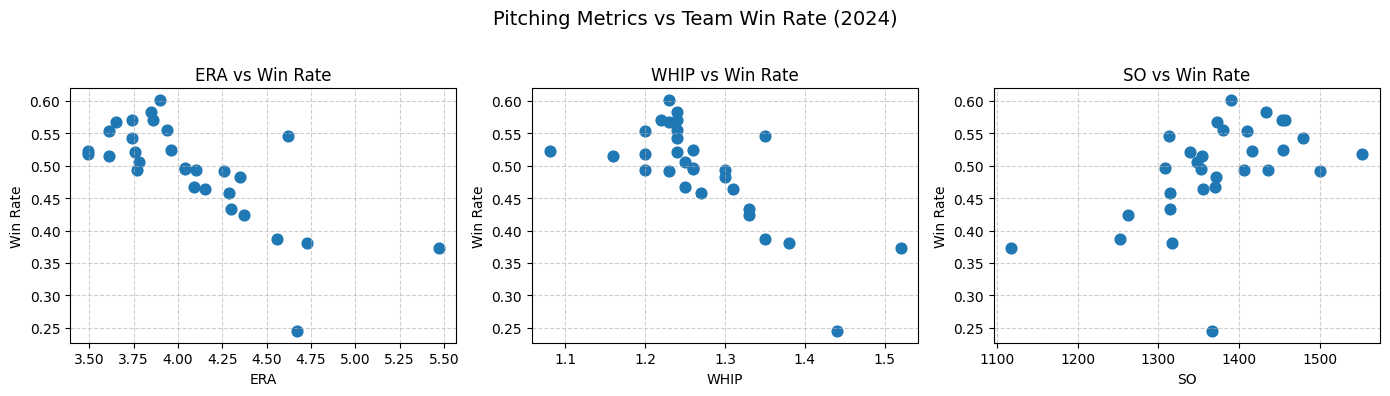

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
pitch_vars = ["ERA","WHIP","SO"]

for i, var in enumerate(pitch_vars):
    axes[i].scatter(team_stats_full_2024[var], team_stats_full_2024["overall_win_rate"], s=60)
    axes[i].set_title(f"{var} vs Win Rate")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Win Rate")
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.suptitle("Pitching Metrics vs Team Win Rate (2024)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


**Pitching Observation:**
Apart from runs allowed (most direct determinant of pitching outcomes), ERA and WHIP have the strongest negative correlations with win-rate. Unlike strikeouts or homeruns, ERA and WHIP are “lower is better” stats, which naturally translates to higher odds of winning.

### Fielding

In [ ]:
# Top defensive teams
fielding_summary = team_stats_full_2024.sort_values("FieldingPct", ascending=False)[
    ["team_name","FieldingPct","Errors","Putouts","Assists","overall_win_rate", "Made_Playoffs"]]
fielding_summary.head(10)


,team_name,FieldingPct,Errors,Putouts,Assists,overall_win_rate,Made_Playoffs
1,Arizona Diamondbacks,0.989,62,4330,1456,0.546,False
12,Minnesota Twins,0.988,70,4321,1230,0.491,False
14,Atlanta Braves,0.988,68,4330,1436,0.517,True
10,St. Louis Cardinals,0.987,75,4332,1525,0.497,False
16,Chicago Cubs,0.987,76,4297,1349,0.506,False
0,San Diego Padres,0.987,75,4318,1297,0.57,True
20,Texas Rangers,0.987,73,4283,1366,0.482,True
17,Colorado Rockies,0.986,82,4280,1564,0.374,False
23,Detroit Tigers,0.986,80,4341,1409,0.515,False
28,Seattle Mariners,0.986,79,4299,1293,0.522,True


In [ ]:
# Ensure defensive stats are numeric
cols_field = ["FieldingPct","Errors","Putouts","Assists"]
for c in cols_field:
    team_stats_full_2024[c] = pd.to_numeric(team_stats_full_2024[c], errors="coerce")

# Defensive summary and correlation with win rate
fielding_corr = (
    team_stats_full_2024[["overall_win_rate","FieldingPct","Errors","Putouts","Assists"]]
    .corr()
    .round(3))
display(fielding_corr)


,overall_win_rate,FieldingPct,Errors,Putouts,Assists
overall_win_rate,1.000,0.394,-0.333,0.581,-0.062
FieldingPct,0.394,1.000,-0.988,0.059,-0.008
Errors,-0.333,-0.988,1.000,0.021,0.063
Putouts,0.581,0.059,0.021,1.000,0.109
Assists,-0.062,-0.008,0.063,0.109,1.000


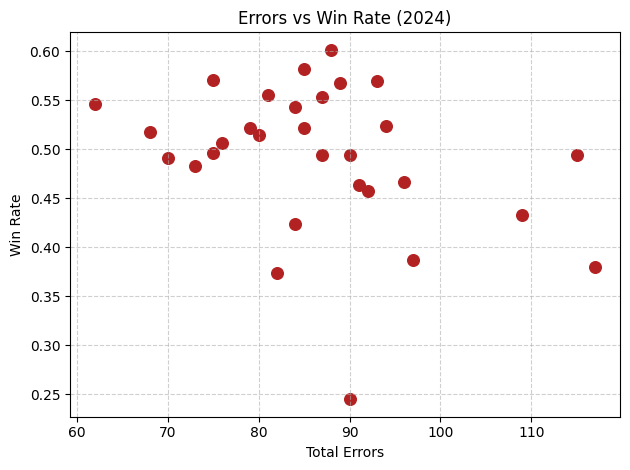

In [ ]:
plt.scatter(team_stats_full_2024["Errors"], team_stats_full_2024["overall_win_rate"], s=70, color="firebrick")
plt.title("Errors vs Win Rate (2024)")
plt.xlabel("Total Errors")
plt.ylabel("Win Rate")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


**Observation:**
Fielding doesn’t drive outcomes as strongly as offense or pitching,
but teams that avoid errors and maintain high fielding percentages tend to have higher win-rates

### Summary across Dimmensions

In [ ]:
team_stats_full_2024[["overall_win_rate","OPS","ERA","WHIP","FieldingPct"]].corr()


,overall_win_rate,OPS,ERA,WHIP,FieldingPct
overall_win_rate,1.000,0.793,-0.715,-0.723,0.394
OPS,0.793,1.000,-0.277,-0.285,0.342
ERA,-0.715,-0.277,1.000,0.926,-0.180
WHIP,-0.723,-0.285,0.926,1.000,-0.235
FieldingPct,0.394,0.342,-0.180,-0.235,1.000


- Offense (OPS, HRs, total runs) was the clearest driver of wins. Disregarding run totals, OPS better correlated to win-rate than AVG.  
- Pitching control (low ERA, WHIP) separated playoff teams from mid-tier team.  
- Defense added marginal but meaningful consistency gains.  


In [ ]:
# Top 5 offensive teams
top_offense = team_stats_full_2024.nlargest(5, "OPS")[["team_name","OPS","Runs","overall_win_rate", "Made_Playoffs"]]

# Top 5 pitching teams (lowest ERA)
top_pitching = team_stats_full_2024.nsmallest(5, "ERA")[["team_name","ERA","WHIP","Runs_Allowed","overall_win_rate", "Made_Playoffs"]]

# Top 5 defensive teams
top_fielding = team_stats_full_2024.nlargest(5, "FieldingPct")[["team_name","FieldingPct","Errors","overall_win_rate", "Made_Playoffs"]]

display(top_offense)
display(top_pitching)
display(top_fielding)

,team_name,OPS,Runs,overall_win_rate,Made_Playoffs
3,Los Angeles Dodgers,0.781,842,0.601,True
1,Arizona Diamondbacks,0.777,886,0.546,False
8,New York Yankees,0.762,815,0.57,True
4,Philadelphia Phillies,0.750,784,0.582,True
6,Baltimore Orioles,0.750,786,0.555,True


,team_name,ERA,WHIP,Runs_Allowed,overall_win_rate,Made_Playoffs
14,Atlanta Braves,3.49,1.20,607,0.517,True
28,Seattle Mariners,3.49,1.08,607,0.522,True
21,Cleveland Guardians,3.61,1.20,621,0.554,True
23,Detroit Tigers,3.61,1.16,642,0.515,False
7,Milwaukee Brewers,3.65,1.23,641,0.567,True


,team_name,FieldingPct,Errors,overall_win_rate,Made_Playoffs
1,Arizona Diamondbacks,0.989,62,0.546,False
12,Minnesota Twins,0.988,70,0.491,False
14,Atlanta Braves,0.988,68,0.517,True
0,San Diego Padres,0.987,75,0.57,True
10,St. Louis Cardinals,0.987,75,0.497,False


### Balanced vs. Specialized Teams

In [ ]:
# Normalize key stats for easy comparison
team_stats_full_2024["OPS_z"] = (team_stats_full_2024["OPS"] - team_stats_full_2024["OPS"].mean()) / team_stats_full_2024["OPS"].std()
team_stats_full_2024["ERA_z"] = (team_stats_full_2024["ERA"] - team_stats_full_2024["ERA"].mean()) / team_stats_full_2024["ERA"].std()
team_stats_full_2024["Fielding_z"] = (team_stats_full_2024["FieldingPct"] - team_stats_full_2024["FieldingPct"].mean()) / team_stats_full_2024["FieldingPct"].std()

# Lower ERA is better, so flip the sign
team_stats_full_2024["ERA_z"] *= -1

# Create a simple "balance index"
team_stats_full_2024["Balance_Index"] = team_stats_full_2024[["OPS_z","ERA_z","Fielding_z"]].mean(axis=1)

# Top balanced teams
top_balanced = team_stats_full_2024.nlargest(10, "Balance_Index")[["team_name","Balance_Index","overall_win_rate", "Made_Playoffs"]]
display(top_balanced)


,team_name,Balance_Index,overall_win_rate,Made_Playoffs
14,Atlanta Braves,1.047,0.517,True
1,Arizona Diamondbacks,0.836,0.546,False
0,San Diego Padres,0.790,0.57,True
3,Los Angeles Dodgers,0.783,0.601,True
4,Philadelphia Phillies,0.693,0.582,True
6,Baltimore Orioles,0.625,0.555,True
8,New York Yankees,0.569,0.57,True
16,Chicago Cubs,0.536,0.506,False
2,Houston Astros,0.525,0.543,True
7,Milwaukee Brewers,0.492,0.567,True


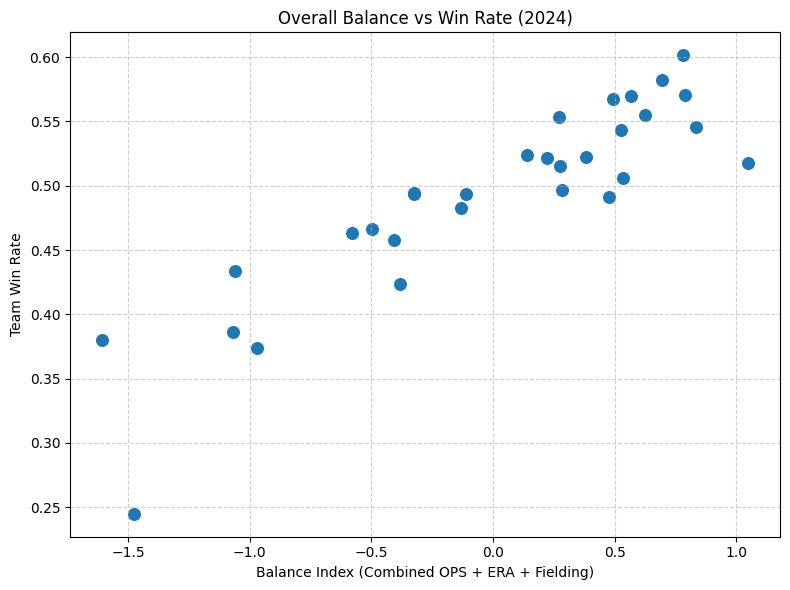

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(team_stats_full_2024["Balance_Index"], team_stats_full_2024["overall_win_rate"], s=70, color="#1f77b4")
plt.title("Overall Balance vs Win Rate (2024)")
plt.xlabel("Balance Index (Combined OPS + ERA + Fielding)")
plt.ylabel("Team Win Rate")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### **Key Insight:** The best teams ranked highly in all three (offense, pitching, and fielding) confirming that winning in MLB 2024 required balance rather than specialization.

###**Part C: Individual Performance Analysis (2024)**

In [ ]:
import numpy as np


In [ ]:
try:
    MLB_SEASON_YEAR
except NameError:
    MLB_SEASON_YEAR = 2024

print(f"Analyzing MLB season: {MLB_SEASON_YEAR}")


Analyzing MLB season: 2024


In [ ]:
# Pulling player stats

# Hitters
hitters_json = mlb_api_get("/stats", {
    "stats": "season",
    "group": "hitting",
    "season": MLB_SEASON_YEAR,
    "sportIds": 1,
    "gameType": "R",
    "playerPool": "ALL",
    "limit": 10000
})

# Pitchers
pitchers_json = mlb_api_get("/stats", {
    "stats": "season",
    "group": "pitching",
    "season": MLB_SEASON_YEAR,
    "sportIds": 1,
    "gameType": "R",
    "playerPool": "ALL",
    "limit": 10000
})

hitters_raw  = pd.json_normalize(hitters_json["stats"][0]["splits"])
pitchers_raw = pd.json_normalize(pitchers_json["stats"][0]["splits"])

print("Hitters:", len(hitters_raw), "Pitchers:", len(pitchers_raw))
display(hitters_raw.head())
display(pitchers_raw.head())


Hitters: 742 Pitchers: 855


,season,numTeams,rank,stat.age,stat.gamesPlayed,stat.groundOuts,stat.airOuts,stat.runs,stat.doubles,stat.triples,stat.homeRuns,stat.strikeOuts,stat.baseOnBalls,stat.intentionalWalks,stat.hits,stat.hitByPitch,stat.avg,stat.atBats,stat.obp,stat.slg,stat.ops,stat.caughtStealing,stat.stolenBases,stat.stolenBasePercentage,stat.caughtStealingPercentage,stat.groundIntoDoublePlay,stat.numberOfPitches,stat.plateAppearances,stat.totalBases,stat.rbi,stat.leftOnBase,stat.sacBunts,stat.sacFlies,stat.babip,stat.groundOutsToAirouts,stat.catchersInterference,stat.atBatsPerHomeRun,team.id,team.name,team.link,player.id,player.fullName,player.link,player.firstName,player.lastName,league.id,league.name,league.link,sport.id,sport.link,sport.abbreviation,position.code,position.name,position.type,position.abbreviation
0,2024,1,1,28,2,1,1,2,1,0,1,0,1,0,3,0,.600,5,.667,1.400,2.067,0,0,.---,.---,0,31,6,7,3,2,0,0,.500,1.00,0,5.00,120,Washington Nationals,/api/v1/teams/120,656448,Stone Garrett,/api/v1/people/656448,Stone,Garrett,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,10,Designated Hitter,Hitter,DH
1,2024,1,2,25,9,3,1,1,2,0,0,3,0,0,7,0,.500,14,.500,.643,1.143,0,0,.---,.---,0,39,14,9,0,4,0,0,.636,3.00,0,-.--,120,Washington Nationals,/api/v1/teams/120,671117,Darren Baker,/api/v1/people/671117,Darren,Baker,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,X,Unknown,Unknown,X
2,2024,1,3,25,3,1,1,2,0,0,0,1,0,0,2,0,.400,5,.400,.400,.800,0,0,.---,.---,0,14,5,2,0,3,0,0,.500,1.00,0,-.--,136,Seattle Mariners,/api/v1/teams/136,669392,Samad Taylor,/api/v1/people/669392,Samad,Taylor,103,AL,/api/v1/league/103,1,/api/v1/sports/1,MLB,7,Outfielder,Outfielder,LF
3,2024,1,4,33,7,2,5,3,4,0,0,5,0,0,7,1,.368,19,.400,.579,.979,0,0,.---,.---,0,75,20,11,2,6,0,0,.500,0.40,0,-.--,113,Cincinnati Reds,/api/v1/teams/113,642851,Austin Wynns,/api/v1/people/642851,Austin,Wynns,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,2,Catcher,Catcher,C
4,2024,1,5,29,30,23,23,15,9,0,3,19,12,0,34,2,.343,99,.425,.525,.950,1,5,.833,.167,2,493,113,52,14,35,0,0,.403,1.00,0,33.00,120,Washington Nationals,/api/v1/teams/120,669743,Alex Call,/api/v1/people/669743,Alex,Call,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,9,Outfielder,Outfielder,RF


,season,numTeams,rank,stat.age,stat.gamesPlayed,stat.gamesStarted,stat.groundOuts,stat.airOuts,stat.runs,stat.doubles,stat.triples,stat.homeRuns,stat.strikeOuts,stat.baseOnBalls,stat.intentionalWalks,stat.hits,stat.hitByPitch,stat.avg,stat.atBats,stat.obp,stat.slg,stat.ops,stat.caughtStealing,stat.stolenBases,stat.stolenBasePercentage,stat.caughtStealingPercentage,stat.groundIntoDoublePlay,stat.numberOfPitches,stat.era,stat.inningsPitched,stat.wins,stat.losses,stat.saves,stat.saveOpportunities,stat.holds,stat.blownSaves,stat.earnedRuns,stat.whip,stat.battersFaced,stat.outs,stat.gamesPitched,stat.completeGames,stat.shutouts,stat.strikes,stat.strikePercentage,stat.hitBatsmen,stat.balks,stat.wildPitches,stat.pickoffs,stat.totalBases,stat.groundOutsToAirouts,stat.winPercentage,stat.pitchesPerInning,stat.gamesFinished,stat.strikeoutWalkRatio,stat.strikeoutsPer9Inn,stat.walksPer9Inn,stat.hitsPer9Inn,stat.runsScoredPer9,stat.homeRunsPer9,stat.inheritedRunners,stat.inheritedRunnersScored,stat.catchersInterference,stat.sacBunts,stat.sacFlies,team.id,team.name,team.link,player.id,player.fullName,player.link,player.firstName,player.lastName,league.id,league.name,league.link,sport.id,sport.link,sport.abbreviation,position.code,position.name,position.type,position.abbreviation
0,2024,1,1,34,1,0,1,1,0,1,0,0,1,0,0,1,1,.250,4,.400,.500,.900,0,0,.---,.---,0,13,0.00,1.0,0,0,0,0,0,0,0,1.00,5,3,1,0,0,8,.620,1,0,0,0,2,1.00,.---,13.00,1,-.--,9.00,0.00,9.00,0.00,0.00,0,0,0,0,0,121,New York Mets,/api/v1/teams/121,657193,Eddy Alvarez,/api/v1/people/657193,Eddy,Alvarez,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,4,Second Base,Infielder,2B
1,2024,1,1,29,2,2,9,5,0,4,0,0,20,1,0,10,0,.227,44,.244,.318,.562,0,0,.---,.---,2,166,0.00,12.0,2,0,0,0,0,0,0,0.92,45,36,2,0,0,110,.660,0,0,0,0,14,1.80,1.000,13.83,0,20.00,15.00,0.75,7.50,0.00,0.00,0,0,0,0,0,114,Cleveland Guardians,/api/v1/teams/114,669456,Shane Bieber,/api/v1/people/669456,Shane,Bieber,103,AL,/api/v1/league/103,1,/api/v1/sports/1,MLB,1,Pitcher,Pitcher,P
2,2024,1,1,31,1,0,1,2,0,1,0,0,0,1,0,1,0,.250,4,.400,.500,.900,0,0,.---,.---,0,15,0.00,1.0,0,0,0,0,0,0,0,2.00,5,3,1,0,0,7,.470,0,0,0,0,2,0.50,.---,15.00,1,0.00,0.00,9.00,9.00,0.00,0.00,0,0,0,0,0,112,Chicago Cubs,/api/v1/teams/112,623520,David Bote,/api/v1/people/623520,David,Bote,104,NL,/api/v1/league/104,1,/api/v1/sports/1,MLB,5,Third Base,Infielder,3B
3,2024,1,1,25,1,0,1,0,0,0,0,0,0,2,0,0,0,.000,1,.667,.000,.667,0,0,.---,.---,0,12,0.00,0.1,0,0,0,0,0,0,0,6.00,3,1,1,0,0,3,.250,0,0,0,0,0,1.00,.---,36.00,1,0.00,0.00,54.00,0.00,0.00,0.00,2,1,0,0,0,147,New York Yankees,/api/v1/teams/147,665828,Oswaldo Cabrera,/api/v1/people/665828,Oswaldo,Cabrera,103,AL,/api/v1/league/103,1,/api/v1/sports/1,MLB,5,Third Base,Infielder,3B
4,2024,1,1,27,2,0,2,2,0,0,0,0,0,0,0,0,0,.000,4,.000,.000,.000,0,0,.---,.---,0,15,0.00,1.1,0,0,0,0,0,0,0,0.00,4,4,2,0,0,9,.600,0,0,0,0,0,1.00,.---,11.25,2,-.--,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,142,Minnesota Twins,/api/v1/teams/142,650489,Willi Castro,/api/v1/people/650489,Willi,Castro,103,AL,/api/v1/league/103,1,/api/v1/sports/1,MLB,7,Outfielder,Outfielder,LF


In [ ]:
# Cleaning and renaming data

# Hitters
hit_cols = ["player.fullName","team.name","stat.gamesPlayed","stat.atBats","stat.hits",
            "stat.homeRuns","stat.runs","stat.rbi",
            "stat.avg","stat.obp","stat.slg","stat.ops"]

hitters = hitters_raw[hit_cols].copy()
hitters.columns = ["Player","Team","Games","AB","Hits","HR","Runs","RBI","AVG","OBP","SLG","OPS"]

for c in ["Games","AB","Hits","HR","Runs","RBI","AVG","OBP","SLG","OPS"]:
    hitters[c] = pd.to_numeric(hitters[c], errors="coerce")

# Pitchers
pitch_cols = ["player.fullName","team.name","stat.gamesPlayed","stat.inningsPitched",
              "stat.era","stat.whip","stat.strikeOuts","stat.baseOnBalls"]

pitchers = pitchers_raw[pitch_cols].copy()
pitchers.columns = ["Player","Team","Games","Innings","ERA","WHIP","K","BB"]

for c in ["Games","Innings","ERA","WHIP","K","BB"]:
    pitchers[c] = pd.to_numeric(pitchers[c], errors="coerce")

print("Hitters:", hitters.shape, "Pitchers:", pitchers.shape)
display(hitters.head())
display(pitchers.head())


Hitters: (742, 12) Pitchers: (855, 8)


,Player,Team,Games,AB,Hits,HR,Runs,RBI,AVG,OBP,SLG,OPS
0,Stone Garrett,Washington Nationals,2,5,3,1,2,3,0.600,0.667,1.400,2.067
1,Darren Baker,Washington Nationals,9,14,7,0,1,0,0.500,0.500,0.643,1.143
2,Samad Taylor,Seattle Mariners,3,5,2,0,2,0,0.400,0.400,0.400,0.800
3,Austin Wynns,Cincinnati Reds,7,19,7,0,3,2,0.368,0.400,0.579,0.979
4,Alex Call,Washington Nationals,30,99,34,3,15,14,0.343,0.425,0.525,0.950


,Player,Team,Games,Innings,ERA,WHIP,K,BB
0,Eddy Alvarez,New York Mets,1,1.0,0.0,1.00,1,0
1,Shane Bieber,Cleveland Guardians,2,12.0,0.0,0.92,20,1
2,David Bote,Chicago Cubs,1,1.0,0.0,2.00,0,1
3,Oswaldo Cabrera,New York Yankees,1,0.1,0.0,6.00,0,2
4,Willi Castro,Minnesota Twins,2,1.1,0.0,0.00,0,0


In [ ]:
# Filtering "qualified" players

# Hitters
qualified_hitters = hitters[hitters["AB"] >= 200].copy()

# Pitchers
qualified_pitchers = pitchers[pitchers["Innings"] >= 50].copy()

print("Qualified hitters:", len(qualified_hitters))
print("Qualified pitchers:", len(qualified_pitchers))

display(qualified_hitters.head())
display(qualified_pitchers.head())


Qualified hitters: 351
Qualified pitchers: 351


,Player,Team,Games,AB,Hits,HR,Runs,RBI,AVG,OBP,SLG,OPS
5,Jose Iglesias,New York Mets,85,270,91,4,39,26,0.337,0.381,0.448,0.829
11,Bobby Witt Jr.,Kansas City Royals,161,636,211,32,125,109,0.332,0.389,0.588,0.977
12,Xavier Edwards,Miami Marlins,70,265,87,1,39,26,0.328,0.397,0.423,0.820
13,Vladimir Guerrero Jr.,Toronto Blue Jays,159,616,199,30,98,103,0.323,0.396,0.544,0.940
14,Aaron Judge,New York Yankees,158,559,180,58,122,144,0.322,0.458,0.701,1.159


,Player,Team,Games,Innings,ERA,WHIP,K,BB
52,Emmanuel Clase,Cleveland Guardians,74,74.1,0.61,0.66,66,10
56,Kirby Yates,Texas Rangers,61,61.2,1.17,0.83,85,28
69,Hunter Gaddis,Cleveland Guardians,78,74.2,1.57,0.76,66,14
76,Bryan Hudson,Milwaukee Brewers,43,62.1,1.73,0.72,62,17
78,Tanner Scott,San Diego Padres,72,72.0,1.75,1.13,84,36


NOTE: We filtered out small-sample players to focus on meaningful performance.

In [ ]:
# Top 10 hitters by OPS and HR

top_ops = qualified_hitters.sort_values("OPS", ascending=False)[["Player","Team","AB","OPS","HR","AVG"]].head(10)
top_hr  = qualified_hitters.sort_values("HR", ascending=False)[["Player","Team","AB","HR","OPS","AVG"]].head(10)

# Top 10 pitchers by ERA and K
top_era = qualified_pitchers.sort_values("ERA", ascending=True)[["Player","Team","Innings","ERA","WHIP","K","BB"]].head(10)
top_k   = qualified_pitchers.sort_values("K", ascending=False)[["Player","Team","Innings","K","ERA","WHIP"]].head(10)

display(top_ops); display(top_hr)
display(top_era); display(top_k)


,Player,Team,AB,OPS,HR,AVG
14,Aaron Judge,New York Yankees,559,1.159,58,0.322
21,Shohei Ohtani,Los Angeles Dodgers,636,1.036,54,0.310
42,Kyle Tucker,Houston Astros,277,0.993,23,0.289
43,Juan Soto,New York Yankees,576,0.988,41,0.288
11,Bobby Witt Jr.,Kansas City Royals,636,0.977,32,0.332
22,Yordan Alvarez,Houston Astros,552,0.959,35,0.308
13,Vladimir Guerrero Jr.,Toronto Blue Jays,616,0.940,30,0.323
51,Kerry Carpenter,Detroit Tigers,264,0.932,18,0.284
39,Ketel Marte,Arizona Diamondbacks,504,0.932,36,0.292
36,Brent Rooker,Oakland Athletics,546,0.927,39,0.293


,Player,Team,AB,HR,OPS,AVG
14,Aaron Judge,New York Yankees,559,58,1.159,0.322
21,Shohei Ohtani,Los Angeles Dodgers,636,54,1.036,0.310
296,Anthony Santander,Baltimore Orioles,595,44,0.814,0.235
43,Juan Soto,New York Yankees,576,41,0.988,0.288
70,José Ramírez,Cleveland Guardians,620,39,0.872,0.279
36,Brent Rooker,Oakland Athletics,546,39,0.927,0.293
28,Marcell Ozuna,Atlanta Braves,606,39,0.924,0.302
214,Kyle Schwarber,Philadelphia Phillies,573,38,0.851,0.248
60,Gunnar Henderson,Baltimore Orioles,630,37,0.893,0.281
39,Ketel Marte,Arizona Diamondbacks,504,36,0.932,0.292


,Player,Team,Innings,ERA,WHIP,K,BB
52,Emmanuel Clase,Cleveland Guardians,74.1,0.61,0.66,66,10
56,Kirby Yates,Texas Rangers,61.2,1.17,0.83,85,28
69,Hunter Gaddis,Cleveland Guardians,74.2,1.57,0.76,66,14
76,Bryan Hudson,Milwaukee Brewers,62.1,1.73,0.72,62,17
78,Tanner Scott,San Diego Padres,72.0,1.75,1.13,84,36
79,Alex Vesia,Los Angeles Dodgers,66.1,1.76,0.99,87,33
84,Matt Strahm,Philadelphia Phillies,62.2,1.87,0.75,79,11
86,Cade Smith,Cleveland Guardians,75.1,1.91,0.90,103,17
87,Ryan Walker,San Francisco Giants,80.0,1.91,0.85,99,18
88,Tim Herrin,Cleveland Guardians,65.2,1.92,0.97,68,25


,Player,Team,Innings,K,ERA,WHIP
129,Tarik Skubal,Detroit Tigers,192.0,228,2.39,0.92
128,Chris Sale,Atlanta Braves,177.2,225,2.38,1.01
142,Zack Wheeler,Philadelphia Phillies,200.0,224,2.57,0.96
288,Dylan Cease,San Diego Padres,189.1,224,3.47,1.07
224,Cole Ragans,Kansas City Royals,186.1,223,3.14,1.14
240,Logan Gilbert,Seattle Mariners,208.2,220,3.23,0.89
307,Garrett Crochet,Chicago White Sox,146.0,209,3.58,1.07
411,Yusei Kikuchi,Houston Astros,175.2,206,4.05,1.20
374,Sonny Gray,St. Louis Cardinals,166.1,203,3.84,1.09
199,Michael King,San Diego Padres,173.2,201,2.95,1.19


NOTE:
- We included OPS, HR, and ERA, which are widely used in modern baseball analytics.
- Additional metrics (OBP, SLG, WHIP, and K/BB ratio) also correlate with winning, but were not included for simplicity.

In [ ]:
# Merging team win rates with players

# Hitters
qualified_hitters = qualified_hitters.rename(columns={"Team":"team"})
hitters_team = qualified_hitters.merge(
    team_summary_2024[["team_name","overall_win_rate"]],
    left_on="team",
    right_on="team_name",
    how="left"
).drop(columns=["team_name"])

# Pitchers
qualified_pitchers = qualified_pitchers.rename(columns={"Team":"team"})
pitchers_team = qualified_pitchers.merge(
    team_summary_2024[["team_name","overall_win_rate"]],
    left_on="team",
    right_on="team_name",
    how="left"
).drop(columns=["team_name"])

display(hitters_team.head())
display(pitchers_team.head())


,Player,team,Games,AB,Hits,HR,Runs,RBI,AVG,OBP,SLG,OPS,overall_win_rate
0,Jose Iglesias,New York Mets,85,270,91,4,39,26,0.337,0.381,0.448,0.829,0.524
1,Bobby Witt Jr.,Kansas City Royals,161,636,211,32,125,109,0.332,0.389,0.588,0.977,0.522
2,Xavier Edwards,Miami Marlins,70,265,87,1,39,26,0.328,0.397,0.423,0.820,0.38
3,Vladimir Guerrero Jr.,Toronto Blue Jays,159,616,199,30,98,103,0.323,0.396,0.544,0.940,0.458
4,Aaron Judge,New York Yankees,158,559,180,58,122,144,0.322,0.458,0.701,1.159,0.57


,Player,team,Games,Innings,ERA,WHIP,K,BB,overall_win_rate
0,Emmanuel Clase,Cleveland Guardians,74,74.1,0.61,0.66,66,10,0.554
1,Kirby Yates,Texas Rangers,61,61.2,1.17,0.83,85,28,0.482
2,Hunter Gaddis,Cleveland Guardians,78,74.2,1.57,0.76,66,14,0.554
3,Bryan Hudson,Milwaukee Brewers,43,62.1,1.73,0.72,62,17,0.567
4,Tanner Scott,San Diego Padres,72,72.0,1.75,1.13,84,36,0.57


NOTE: We merged individual performance with team-level win rates to analyze whether elite player metrics correlate with team success.

In [ ]:
# Correlations

# Hitter correlations
corr_hitters = hitters_team[["OPS","HR","AVG","overall_win_rate"]].corr()

# Pitcher K/BB ratio (proxy for pitcher efficiency)
pitchers_team["K_BB_ratio"] = pitchers_team["K"] / pitchers_team["BB"].replace(0, np.nan)

# Pitcher correlations
corr_pitchers = pitchers_team[["ERA","WHIP","K_BB_ratio","overall_win_rate"]].corr()

display(corr_hitters)
display(corr_pitchers)


,OPS,HR,AVG,overall_win_rate
OPS,1.000,0.722,0.769,0.263
HR,0.722,1.000,0.319,0.179
AVG,0.769,0.319,1.000,0.207
overall_win_rate,0.263,0.179,0.207,1.000


,ERA,WHIP,K_BB_ratio,overall_win_rate
ERA,1.000,0.786,-0.437,-0.278
WHIP,0.786,1.000,-0.690,-0.281
K_BB_ratio,-0.437,-0.690,1.000,0.207
overall_win_rate,-0.278,-0.281,0.207,1.000


NOTE:
- OPS has the strongest positive relationship with winning among hitter stats.
- HR and AVG also trend upward with win rate, but less strongly than OPS.
- ERA and WHIP show the strongest relationships overall
- K/BB ratio is positively associated with winning, reflecting the importance of strikeouts and limiting walks.
- Overall, pitching metrics show slightly stronger links to team success than hitting metrics, suggesting elite pitching provides a meaningful competitive edge

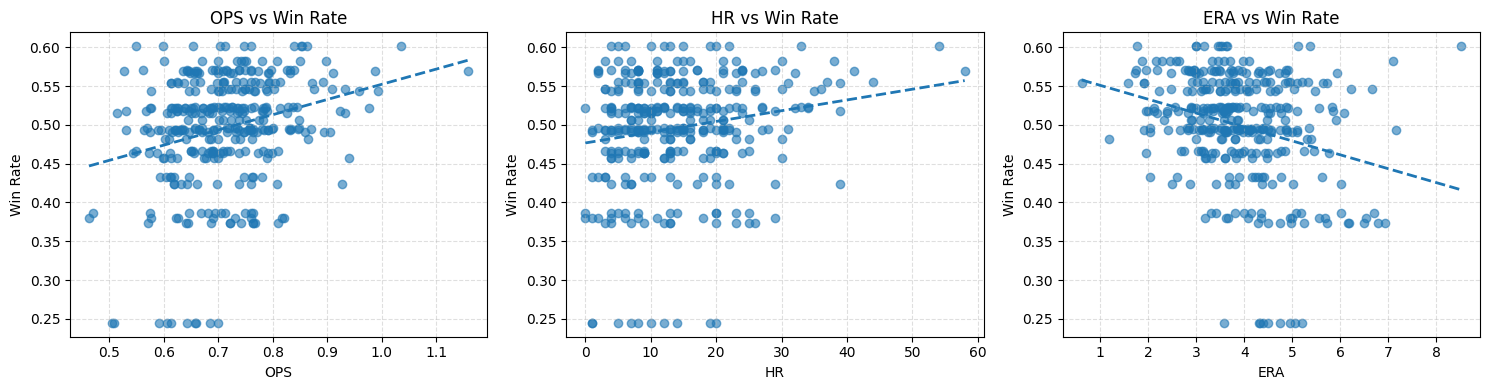

In [ ]:
def add_trend(ax, x, y):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(min(x), max(x), 100)
    ax.plot(xs, m*xs + b, "--", lw=2)

fig, axes = plt.subplots(1,3, figsize=(15,4))

pairs = [
    ("OPS", "OPS vs Win Rate"),
    ("HR",  "HR vs Win Rate"),
    ("ERA", "ERA vs Win Rate")
]

for ax, (stat, title) in zip(axes, pairs):
    if stat == "ERA":
        x = pitchers_team[stat]; y = pitchers_team["overall_win_rate"]
    else:
        x = hitters_team[stat]; y = hitters_team["overall_win_rate"]

    ax.scatter(x, y, alpha=0.6)
    add_trend(ax, x, y)
    ax.set_title(title)
    ax.set_xlabel(stat)
    ax.set_ylabel("Win Rate")
    ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
# Win rates with elite players

# "Elite" cutoffs
elite_hitters = hitters_team[hitters_team["OPS"] >= 0.900]
elite_pitchers = pitchers_team[pitchers_team["ERA"] <= 3.00]

# Hitters
elite_hit_rate = elite_hitters["overall_win_rate"].mean()
non_elite_hit_rate = hitters_team[hitters_team["OPS"] < 0.900]["overall_win_rate"].mean()

# Pitchers
elite_pitch_rate = elite_pitchers["overall_win_rate"].mean()
non_elite_pitch_rate = pitchers_team[pitchers_team["ERA"] > 3.00]["overall_win_rate"].mean()


elite_hit_rate = float(elite_hit_rate)
non_elite_hit_rate = float(non_elite_hit_rate)
elite_pitch_rate = float(elite_pitch_rate)
non_elite_pitch_rate = float(non_elite_pitch_rate)

print(f"Elite Hitters Win Rate:     {elite_hit_rate:.3f}")
print(f"Non-Elite Hitters Win Rate: {non_elite_hit_rate:.3f}")
print(f"Elite Pitchers Win Rate:    {elite_pitch_rate:.3f}")
print(f"Non-Elite Pitchers Win Rate:{non_elite_pitch_rate:.3f}")


Elite Hitters Win Rate:     0.530
Non-Elite Hitters Win Rate: 0.495
Elite Pitchers Win Rate:    0.530
Non-Elite Pitchers Win Rate:0.492


NOTE:
- Teams with elite talent win more often
- A single elite hitter or pitcher is associated with ~3–4% higher win rate

#### **Key Insight:** In 2024, teams with top-performing hitters (higher OPS and HRs) and pitchers (lower ERA) tended to win more games, with elite talent associated with roughly a 3–4% higher win rate. Overall, having an elite hitter or pitcher provided a measurable advantage, reinforcing the impact of standout individual performance on team success.

###**Part D: Conclusion**

Looking at the 2024 season, the biggest takeaway is that balanced teams win. Clubs that combined good hitting, solid pitching, and reliable defense were almost always the ones playing in October.
Offense mattered most — higher OPS and total runs had the strongest link to winning — but teams that paired that with strong pitching (low ERA and WHIP) consistently finished near the top. Fielding didn’t drive results as directly, but clean defensive play still separated great teams from average ones.

At the player level, we saw the same pattern. Teams with elite hitters (OPS above .900) or elite pitchers (ERA below 3.00) won more often — roughly a 3–4% higher win rate. That shows how standout individual talent lifts team performance, but also that success comes from depth across the roster, not one star.

If we had more time, we’d expand beyond 2024 to look at how the game has changed over the past 30 years — from the power surge of the 1990s to the pitching dominance of recent seasons. We’d also bring in new data like team payroll, ballpark effects, and weather to see how spending and environment shape results. In the future, adding Statcast data (like exit velocity or spin rate) could help identify which player skills translate most directly into wins — insights that would be useful for MLB front offices and analytics teams.